Add Robin boundary conditions.

Success!

Author: yanjun zhang

# ds needs define correct

## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

In [1]:
import pyvista
import ufl
import dolfinx
import time
import numpy as np
import matplotlib.pyplot as plt
from petsc4py import PETSc
from mpi4py import MPI
import sys

from dolfinx.fem.petsc import LinearProblem,assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, 
                         form,  locate_dofs_topological)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import  locate_entities, locate_entities_boundary,meshtags
from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner, Measure, dot, FacetNormal)

from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

from find_com_e import find_common_e

# Start time, Final time ,Time step
t = 0
Total_time = 10
num_steps  = 100
# time step size
dt = Total_time / num_steps  

# initial and brake pad temperature
Ti = 25
Tm = 25

# density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
t_u = 1e3 # m to mm
rho = 7850 /(t_u**3)
c = 462
k = 48 / t_u

# mu, P_brake, v_angualr , r_disc , heat_distribution
mu = 0.35
P_brake = 246000
v_angualr = 48.3
r_disc = 0.25
heat_distribution = 0.88

# S_or is the original brake pad rubbing area, 200 cm2. 
S_or = 200
S_new = 200

# g is the heat source,unit is w/mm2
g = mu * P_brake * v_angualr * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) *100
h = g/200  *0.1
radiation = 5.670*(10e-8)*0.5  *0.00000000000000001

print(v_angualr * r_disc * dt *1000)
print('heat flux g is ',g)
print('time step dt is ',dt)
print('radiation is ',radiation)

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


1207.5
heat flux g is  182.97972
time step dt is  0.1
radiation is  2.835e-24


In [2]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

DOLFINx version: 0.7.3   based on GIT commit:  ubuntu of https://github.com/FEniCS/dolfinx/


## 2: Mesh

In [3]:
# mesh
filename = "3-10" 
domain, cell_markers, facet_markers = gmshio.read_from_msh(filename+".msh", MPI.COMM_WORLD, 0, gdim=3)

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('Lagrange', 1))

# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()
    
# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = FunctionSpace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init,V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 50) )
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V)

Info    : Reading '3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading '3-10.msh'


In [4]:
np.set_printoptions(threshold=np.inf)
print(type(PETSc.ScalarType(Tm)))
print(fem.locate_dofs_topological(V, fdim, bc_disc))
print(bc)

<class 'numpy.float64'>
[]


## 3: Setup output


In [5]:
xdmf = io.XDMFFile(domain.comm, "T4.xdmf", "w")
xdmf.write_mesh(domain)

boundaries = []
for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
    vari_name = 10*i
    boundaries.append(  (vari_name, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324)  )

In [6]:
# Create boundary condition
import sys
sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
from rub_co import get_rub_coordinate
x_co, y_co = get_rub_coordinate()

boundary1= (10, lambda x: (x[0]-x_co[0])**2 + (x[1]-y_co[0])**2 <= 324)
boundary2= (20, lambda x: (x[0]-x_co[1])**2 + (x[1]-y_co[1])**2 <= 324) 
boundary3= (30, lambda x: (x[0]-x_co[2])**2 + (x[1]-y_co[2])**2 <= 324)
boundary4= (40, lambda x: (x[0]-x_co[3])**2 + (x[1]-y_co[3])**2 <= 324) 
boundary5= (50, lambda x: (x[0]-x_co[4])**2 + (x[1]-y_co[4])**2 <= 324)
boundary6= (60, lambda x: (x[0]-x_co[5])**2 + (x[1]-y_co[5])**2 <= 324) 
boundary7= (70, lambda x: (x[0]-x_co[6])**2 + (x[1]-y_co[6])**2 <= 324)
boundary8= (80, lambda x: (x[0]-x_co[7])**2 + (x[1]-y_co[7])**2 <= 324) 
boundary9= (90, lambda x: (x[0]-x_co[8])**2 + (x[1]-y_co[8])**2 <= 324)
boundary10= (100, lambda x: (x[0]-x_co[9])**2 + (x[1]-y_co[9])**2 <= 324) 
boundary11= (110, lambda x: (x[0]-x_co[10])**2 + (x[1]-y_co[10])**2 <= 324)
boundary12= (120, lambda x: (x[0]-x_co[11])**2 + (x[1]-y_co[11])**2 <= 324) 
boundary13= (130, lambda x: (x[0]-x_co[12])**2 + (x[1]-y_co[12])**2 <= 324)
boundary14= (140, lambda x: (x[0]-x_co[13])**2 + (x[1]-y_co[13])**2 <= 324) 
boundary15= (150, lambda x: (x[0]-x_co[14])**2 + (x[1]-y_co[14])**2 <= 324)
boundary16= (160, lambda x: (x[0]-x_co[15])**2 + (x[1]-y_co[15])**2 <= 324)
boundary17= (170, lambda x: (x[0]-x_co[16])**2 + (x[1]-y_co[16])**2 <= 324) 
boundary18= (180, lambda x: (x[0]-x_co[17])**2 + (x[1]-y_co[17])**2 <= 324)

boundaries1 = [boundary1,boundary2,boundary3,boundary4,boundary5,boundary6,boundary7,boundary8,boundary9,boundary10,
              boundary11,boundary12,boundary13,boundary14,boundary15,boundary16,boundary17,boundary18]
 
facet_indices1, facet_markers1 = [], [] 
fdim = domain.topology.dim - 1  
for (marker, locator) in boundaries1:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices1.append(facets)
        facet_markers1.append(np.full_like(facets, marker))
facet_indices1 = np.hstack(facet_indices1).astype(np.int32)
facet_markers1 = np.hstack(facet_markers1).astype(np.int32)
            
A1 = facet_indices1
B = facet_markers1 
C = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 20) )

common_indices1 = np.intersect1d(A1,C)
D = []
for index in common_indices1:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
facet_markers1 = np.concatenate(D)
####################################

boundary20 = (200, lambda x:  x[2] == 20)
facet_indices2, facet_markers2 = [], [] 
fdim = domain.topology.dim - 1  
for (marker, locator) in [boundary20]:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices2.append(facets)
        facet_markers2.append(np.full_like(facets, marker)) 
facet_indices2 = np.hstack(facet_indices2).astype(np.int32)
facet_markers2 = np.hstack(facet_markers2).astype(np.int32)

A1 = facet_indices2
B = facet_markers2
B1 = common_indices1
common_indices2 = np.setdiff1d(A1,B1)
D = []
for index in common_indices2:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
facet_markers2 = np.concatenate(D) 
    
common_indices3 = [common_indices1,common_indices2]
facet_markers3 = [facet_markers1,facet_markers2]
common_indices3 = np.concatenate(common_indices3)
facet_markers3 = np.concatenate(facet_markers3)
sorted_indices3 = np.argsort(common_indices3)
      
facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


In [7]:
#print(facet_markers1)
#print(facet_markers3)


## 4: Variational equation


In [8]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init,V)
xdmf.write_function(uh, t)

#u = ufl.TrialFunction(V)
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200) \
- ( inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200) )

#a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200)
#L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200)


for i in list(range(1,19)):
     F +=  - k * dot( grad(u)* v, n_vector) *ds(10*i) - inner(g, v) *ds(10*i)

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert (converged)
print(f"Number of interations: {n:d}")


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl
pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()
plotter.open_gif("T4.gif", fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)
renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[0,  200])

2024-04-14 18:25:24.941 (   2.331s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:25.051 (   2.441s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:25.113 (   2.502s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00806217 (tol = 1e-10) r (rel) = 3.62076e-07(tol = 1e-06)
2024-04-14 18:25:25.113 (   2.502s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.


Number of interations: 2


## 5: Solution


In [9]:
from rotation_co import rub_rotation
import numpy as np

degree = 10
total_degree = 0

for i in range(num_steps):
    t += dt
   
    boundaries1 = []
    x_co, y_co = rub_rotation (x_co, y_co, degree)   # update the location
    total_degree += degree  # Incrementing degree by 10 in each step
    
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/Total_time),1) )+ " %. ")
    sys.stdout.flush()
    
    boundary1= (10, lambda x: (x[0]-x_co[0])**2 + (x[1]-y_co[0])**2 <= 324)
    boundary2= (20, lambda x: (x[0]-x_co[1])**2 + (x[1]-y_co[1])**2 <= 324) 
    boundary3= (30, lambda x: (x[0]-x_co[2])**2 + (x[1]-y_co[2])**2 <= 324)
    boundary4= (40, lambda x: (x[0]-x_co[3])**2 + (x[1]-y_co[3])**2 <= 324) 
    boundary5= (50, lambda x: (x[0]-x_co[4])**2 + (x[1]-y_co[4])**2 <= 324)
    boundary6= (60, lambda x: (x[0]-x_co[5])**2 + (x[1]-y_co[5])**2 <= 324) 
    boundary7= (70, lambda x: (x[0]-x_co[6])**2 + (x[1]-y_co[6])**2 <= 324)
    boundary8= (80, lambda x: (x[0]-x_co[7])**2 + (x[1]-y_co[7])**2 <= 324) 
    boundary9= (90, lambda x: (x[0]-x_co[8])**2 + (x[1]-y_co[8])**2 <= 324)
    boundary10= (100, lambda x: (x[0]-x_co[9])**2 + (x[1]-y_co[9])**2 <= 324) 
    boundary11= (110, lambda x: (x[0]-x_co[10])**2 + (x[1]-y_co[10])**2 <= 324)
    boundary12= (120, lambda x: (x[0]-x_co[11])**2 + (x[1]-y_co[11])**2 <= 324) 
    boundary13= (130, lambda x: (x[0]-x_co[12])**2 + (x[1]-y_co[12])**2 <= 324)
    boundary14= (140, lambda x: (x[0]-x_co[13])**2 + (x[1]-y_co[13])**2 <= 324) 
    boundary15= (150, lambda x: (x[0]-x_co[14])**2 + (x[1]-y_co[14])**2 <= 324)
    boundary16= (160, lambda x: (x[0]-x_co[15])**2 + (x[1]-y_co[15])**2 <= 324)
    boundary17= (170, lambda x: (x[0]-x_co[16])**2 + (x[1]-y_co[16])**2 <= 324) 
    boundary18= (180, lambda x: (x[0]-x_co[17])**2 + (x[1]-y_co[17])**2 <= 324)
   
    boundaries1 = [boundary1,boundary2,boundary3,boundary4,boundary5,boundary6,boundary7,boundary8,boundary9,boundary10,
              boundary11,boundary12,boundary13,boundary14,boundary15,boundary16,boundary17,boundary18]
    #boundaries = boundaries+ [boundary19]
 
    facet_indices1, facet_markers1 = [], [] 
    fdim = domain.topology.dim - 1  
    for (marker, locator) in boundaries1:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices1.append(facets)
        facet_markers1.append(np.full_like(facets, marker))  
    facet_indices1 = np.hstack(facet_indices1).astype(np.int32)
    facet_markers1 = np.hstack(facet_markers1).astype(np.int32)
    bc_disc = mesh.locate_entities_boundary( domain, fdim , lambda x:  np.isclose(x[2], 20) )        
    A1 = facet_indices1
    B = facet_markers1 
    C = bc_disc
    common_indices1 = np.intersect1d(A1,C)
    D = []
    for index in common_indices1:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
    facet_markers1 = np.concatenate(D)
    ####################################

    
    boundary20 = (200, lambda x:  x[2] == 20)
    facet_indices2, facet_markers2 = [], [] 
    fdim = domain.topology.dim - 1  
    for (marker, locator) in [boundary20]:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices2.append(facets)
        facet_markers2.append(np.full_like(facets, marker)) 
    facet_indices2 = np.hstack(facet_indices2).astype(np.int32)
    facet_markers2 = np.hstack(facet_markers2).astype(np.int32) 
    
    A1 = facet_indices2
    B = facet_markers2
    B1 = common_indices1
    common_indices2 = np.setdiff1d(A1,B1)
    D = []
    for index in common_indices2:
           rows_A1 = np.where(A1 == index)
           D.append( B[rows_A1] )
    facet_markers2 = np.concatenate(D) 
    
    common_indices3 = [common_indices1,common_indices2]
    facet_markers3 = [facet_markers1,facet_markers2]
    common_indices3 = np.concatenate(common_indices3)
    facet_markers3 = np.concatenate(facet_markers3)

    sorted_indices3 = np.argsort(common_indices3)
      
    facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
    ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 

    F = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200) \
    - ( inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200) )

    for i in list(range(1,19)):
         F +=  - k * dot( grad(u)* v, n_vector) *ds(10*i) - inner(g, v) *ds(10*i)

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-2
    
    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()


1: Rotation has applied for 10 degree. 2: Current time is 0.1 s. 3: Completion is 1.0 %. 

2024-04-14 18:25:28.382 (   5.771s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:28.382 (   5.771s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:28.382 (   5.771s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:28.382 (   5.772s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:28.383 (   5.772s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:28.383 (   5.777s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:28.388 (   5.777s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:28.388 (   5.778s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:28.388 (   5.778s) [mai

1: Rotation has applied for 20 degree. 2: Current time is 0.2 s. 3: Completion is 2.0 %. 

2024-04-14 18:25:29.107 (   6.496s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.107 (   6.497s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.108 (   6.497s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:29.108 (   6.497s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.108 (   6.498s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.108 (   6.498s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:29.108 (   6.498s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.109 (   6.498s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.109 (   6.498s) [mai

1: Rotation has applied for 30 degree. 2: Current time is 0.3 s. 3: Completion is 3.0 %. 

2024-04-14 18:25:29.314 (   6.704s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:29.374 (   6.763s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.248585 (tol = 1e-10) r (rel) = 9.42912e-06(tol = 0.01)
2024-04-14 18:25:29.374 (   6.764s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:29.376 (   6.766s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:29.454 (   6.843s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.454 (   6.843s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.454 (   6.844s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:29.455 (  

1: Rotation has applied for 40 degree. 2: Current time is 0.4 s. 3: Completion is 4.0 %. 

2024-04-14 18:25:29.679 (   7.068s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:29.740 (   7.133s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00712202 (tol = 1e-10) r (rel) = 2.59007e-07(tol = 0.01)
2024-04-14 18:25:29.744 (   7.133s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:29.747 (   7.136s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:29.836 (   7.225s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.836 (   7.226s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:29.836 (   7.226s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:29.837 (

1: Rotation has applied for 50 degree. 2: Current time is 0.5 s. 3: Completion is 5.0 %. 

2024-04-14 18:25:29.965 (   7.355s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:30.063 (   7.452s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:30.116 (   7.508s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.273628 (tol = 1e-10) r (rel) = 9.64246e-06(tol = 0.01)
2024-04-14 18:25:30.118 (   7.508s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:30.119 (   7.508s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:30.182 (   7.572s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.183 (   7.572s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 60 degree. 2: Current time is 0.6 s. 3: Completion is 6.0 %. 

2024-04-14 18:25:30.526 (   7.915s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.528 (   7.917s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.528 (   7.917s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:30.528 (   7.917s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.528 (   7.917s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.528 (   7.918s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:30.529 (   7.918s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.529 (   7.918s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.529 (   7.918s) [mai

1: Rotation has applied for 70 degree. 2: Current time is 0.7 s. 3: Completion is 7.0 %. 

2024-04-14 18:25:30.758 (   8.147s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:30.835 (   8.224s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00987193 (tol = 1e-10) r (rel) = 3.42653e-07(tol = 0.01)
2024-04-14 18:25:30.835 (   8.224s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:30.836 (   8.225s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:30.911 (   8.300s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.911 (   8.301s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:30.911 (   8.301s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:30.912 (

1: Rotation has applied for 80 degree. 2: Current time is 0.8 s. 3: Completion is 8.0 %. 

2024-04-14 18:25:31.051 (   8.440s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:31.152 (   8.542s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:31.209 (   8.598s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00966275 (tol = 1e-10) r (rel) = 3.745e-07(tol = 0.01)
2024-04-14 18:25:31.209 (   8.599s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:31.209 (   8.599s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:31.272 (   8.661s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:31.272 (   8.661s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 90 degree. 2: Current time is 0.9 s. 3: Completion is 9.0 %. 

2024-04-14 18:25:31.632 (   9.021s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:31.633 (   9.022s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:31.633 (   9.022s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:31.633 (   9.023s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:31.634 (   9.023s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:31.634 (   9.023s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:31.634 (   9.023s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:31.634 (   9.024s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:31.634 (   9.024s) [mai

1: Rotation has applied for 100 degree. 2: Current time is 1.0 s. 3: Completion is 10.0 %. 

2024-04-14 18:25:31.763 (   9.153s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:31.954 (   9.343s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:32.079 (   9.468s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.198648 (tol = 1e-10) r (rel) = 9.45187e-06(tol = 0.01)
2024-04-14 18:25:32.079 (   9.468s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:32.079 (   9.468s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:32.160 (   9.549s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:32.160 (   9.549s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 110 degree. 2: Current time is 1.1 s. 3: Completion is 11.0 %. 

2024-04-14 18:25:32.220 (   9.610s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 18:25:32.220 (   9.610s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 18:25:32.224 (   9.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 18:25:32.242 (   9.632s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 18:25:32.274 (   9.664s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:32.399 (   9.788s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:32.468 (   9.857s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0071632 (tol = 1e-10) r (rel) = 3.44329e-07(tol = 0.01)
2024-04-14 18:25:32.468 (   9.857s) [main            ]      

1: Rotation has applied for 120 degree. 2: Current time is 1.2 s. 3: Completion is 12.0 %. 

2024-04-14 18:25:32.825 (  10.215s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.213531 (tol = 1e-10) r (rel) = 1.02722e-05(tol = 0.01)
2024-04-14 18:25:32.825 (  10.215s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:32.826 (  10.215s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:32.893 (  10.282s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:32.893 (  10.283s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:32.893 (  10.283s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:32.894 (  10.283s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:32.894 (  10.283s) [main  

1: Rotation has applied for 130 degree. 2: Current time is 1.3 s. 3: Completion is 13.0 %. 

2024-04-14 18:25:33.188 (  10.577s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:33.371 (  10.760s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00528428 (tol = 1e-10) r (rel) = 2.64316e-07(tol = 0.01)
2024-04-14 18:25:33.371 (  10.760s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:33.372 (  10.761s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:33.455 (  10.844s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:33.456 (  10.845s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:33.456 (  10.845s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:33.456 (

1: Rotation has applied for 140 degree. 2: Current time is 1.4 s. 3: Completion is 14.0 %. 

2024-04-14 18:25:33.865 (  11.255s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:33.866 (  11.255s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:33.866 (  11.255s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:33.866 (  11.255s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:33.866 (  11.256s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:33.866 (  11.256s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:33.867 (  11.256s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:33.867 (  11.256s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:33.867 (  11.256s) [mai

1: Rotation has applied for 150 degree. 2: Current time is 1.5 s. 3: Completion is 15.0 %. 

2024-04-14 18:25:34.115 (  11.504s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:34.174 (  11.564s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.19528 (tol = 1e-10) r (rel) = 9.75682e-06(tol = 0.01)
2024-04-14 18:25:34.174 (  11.564s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:34.175 (  11.565s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:34.233 (  11.622s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:34.233 (  11.622s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:34.233 (  11.623s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:34.233 (  1

1: Rotation has applied for 160 degree. 2: Current time is 1.6 s. 3: Completion is 16.0 %. 

2024-04-14 18:25:34.732 (  12.121s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:34.732 (  12.121s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:34.732 (  12.121s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:34.732 (  12.122s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:34.733 (  12.122s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:34.733 (  12.122s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:34.733 (  12.123s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:34.734 (  12.123s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:34.734 (  12.123s) [mai

1: Rotation has applied for 170 degree. 2: Current time is 1.7 s. 3: Completion is 17.0 %. 

2024-04-14 18:25:34.964 (  12.353s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:35.032 (  12.421s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00507996 (tol = 1e-10) r (rel) = 2.60485e-07(tol = 0.01)
2024-04-14 18:25:35.032 (  12.421s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:35.032 (  12.421s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:35.102 (  12.491s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:35.102 (  12.492s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:35.103 (  12.492s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:35.103 (

1: Rotation has applied for 180 degree. 2: Current time is 1.8 s. 3: Completion is 18.0 %. 

2024-04-14 18:25:35.176 (  12.566s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 18:25:35.194 (  12.584s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 18:25:35.227 (  12.616s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:35.325 (  12.714s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:35.384 (  12.777s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0048521 (tol = 1e-10) r (rel) = 2.47638e-07(tol = 0.01)
2024-04-14 18:25:35.388 (  12.777s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:35.389 (  12.778s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"


1: Rotation has applied for 190 degree. 2: Current time is 1.9 s. 3: Completion is 19.0 %. 

2024-04-14 18:25:35.798 (  13.187s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:35.868 (  13.258s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0056829 (tol = 1e-10) r (rel) = 2.76967e-07(tol = 0.01)
2024-04-14 18:25:35.868 (  13.258s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:35.869 (  13.258s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:35.939 (  13.328s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:35.939 (  13.328s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:35.939 (  13.328s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:35.939 ( 

1: Rotation has applied for 200 degree. 2: Current time is 2.0 s. 3: Completion is 20.0 %. 

2024-04-14 18:25:36.074 (  13.463s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:36.183 (  13.572s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:36.239 (  13.628s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.192394 (tol = 1e-10) r (rel) = 9.75301e-06(tol = 0.01)
2024-04-14 18:25:36.239 (  13.629s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:36.240 (  13.629s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:36.300 (  13.689s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:36.301 (  13.690s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 210 degree. 2: Current time is 2.1 s. 3: Completion is 21.0 %. 

2024-04-14 18:25:36.563 (  13.952s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:36.644 (  14.034s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.180461 (tol = 1e-10) r (rel) = 8.93212e-06(tol = 0.01)
2024-04-14 18:25:36.645 (  14.034s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:36.645 (  14.034s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:36.703 (  14.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:36.704 (  14.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:36.704 (  14.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:36.704 (  

1: Rotation has applied for 220 degree. 2: Current time is 2.2 s. 3: Completion is 22.0 %. 

2024-04-14 18:25:36.919 (  14.309s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:37.096 (  14.485s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.211398 (tol = 1e-10) r (rel) = 1.03746e-05(tol = 0.01)
2024-04-14 18:25:37.096 (  14.485s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:37.096 (  14.485s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:37.183 (  14.573s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:37.184 (  14.573s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:37.184 (  14.573s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:37.184 (  

1: Rotation has applied for 230 degree. 2: Current time is 2.3 s. 3: Completion is 23.0 %. 

2024-04-14 18:25:37.408 (  14.797s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:37.492 (  14.881s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00480998 (tol = 1e-10) r (rel) = 2.49823e-07(tol = 0.01)
2024-04-14 18:25:37.492 (  14.881s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:37.493 (  14.882s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:37.552 (  14.941s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:37.552 (  14.941s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:37.552 (  14.941s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:37.552 (

1: Rotation has applied for 240 degree. 2: Current time is 2.4 s. 3: Completion is 24.0 %. 

2024-04-14 18:25:37.670 (  15.059s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:37.763 (  15.153s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:37.816 (  15.206s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.174205 (tol = 1e-10) r (rel) = 8.58794e-06(tol = 0.01)
2024-04-14 18:25:37.819 (  15.208s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:37.819 (  15.208s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:37.873 (  15.262s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:37.873 (  15.262s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 250 degree. 2: Current time is 2.5 s. 3: Completion is 25.0 %. 

2024-04-14 18:25:38.012 (  15.402s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:38.132 (  15.521s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:38.192 (  15.581s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.193498 (tol = 1e-10) r (rel) = 1.01324e-05(tol = 0.01)
2024-04-14 18:25:38.194 (  15.583s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:38.194 (  15.583s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:38.250 (  15.639s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:38.250 (  15.640s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 260 degree. 2: Current time is 2.6 s. 3: Completion is 26.0 %. 

2024-04-14 18:25:38.481 (  15.870s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:38.552 (  15.941s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.158783 (tol = 1e-10) r (rel) = 8.06116e-06(tol = 0.01)
2024-04-14 18:25:38.552 (  15.941s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:38.552 (  15.941s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:38.617 (  16.007s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:38.618 (  16.007s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:38.618 (  16.007s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:38.618 (  

1: Rotation has applied for 270 degree. 2: Current time is 2.7 s. 3: Completion is 27.0 %. 

2024-04-14 18:25:38.752 (  16.141s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:38.868 (  16.257s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:38.939 (  16.328s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.198948 (tol = 1e-10) r (rel) = 1.02977e-05(tol = 0.01)
2024-04-14 18:25:38.939 (  16.329s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:38.940 (  16.329s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:38.998 (  16.387s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:38.998 (  16.387s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 280 degree. 2: Current time is 2.8 s. 3: Completion is 28.0 %. 

2024-04-14 18:25:39.314 (  16.703s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.198471 (tol = 1e-10) r (rel) = 1.01338e-05(tol = 0.01)
2024-04-14 18:25:39.314 (  16.704s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:39.315 (  16.704s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:39.394 (  16.783s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:39.394 (  16.783s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:39.394 (  16.783s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:39.394 (  16.784s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:39.395 (  16.784s) [main  

1: Rotation has applied for 290 degree. 2: Current time is 2.9 s. 3: Completion is 29.0 %. 

2024-04-14 18:25:39.656 (  17.046s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:39.723 (  17.113s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00480071 (tol = 1e-10) r (rel) = 2.4449e-07(tol = 0.01)
2024-04-14 18:25:39.723 (  17.113s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:39.724 (  17.113s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:39.800 (  17.189s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:39.800 (  17.190s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:39.800 (  17.190s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:39.801 ( 

1: Rotation has applied for 300 degree. 2: Current time is 3.0 s. 3: Completion is 30.0 %. 

2024-04-14 18:25:40.336 (  17.725s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.336 (  17.725s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.336 (  17.726s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:40.337 (  17.726s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.337 (  17.726s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.337 (  17.726s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:40.337 (  17.727s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.338 (  17.727s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.338 (  17.727s) [mai

1: Rotation has applied for 310 degree. 2: Current time is 3.1 s. 3: Completion is 31.0 %. 

2024-04-14 18:25:40.620 (  18.010s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.237382 (tol = 1e-10) r (rel) = 9.78461e-06(tol = 0.01)
2024-04-14 18:25:40.620 (  18.010s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:40.621 (  18.011s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:40.730 (  18.119s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.730 (  18.120s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.730 (  18.120s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:40.731 (  18.120s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:40.731 (  18.120s) [main  

1: Rotation has applied for 320 degree. 2: Current time is 3.2 s. 3: Completion is 32.0 %. 

2024-04-14 18:25:41.135 (  18.524s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:41.198 (  18.589s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.223704 (tol = 1e-10) r (rel) = 9.09979e-06(tol = 0.01)
2024-04-14 18:25:41.200 (  18.594s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:41.205 (  18.594s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:41.258 (  18.647s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:41.259 (  18.648s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:41.259 (  18.648s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:41.259 (  

1: Rotation has applied for 330 degree. 2: Current time is 3.3 s. 3: Completion is 33.0 %. 

2024-04-14 18:25:41.385 (  18.774s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:41.484 (  18.873s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:41.549 (  18.938s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.239825 (tol = 1e-10) r (rel) = 8.97313e-06(tol = 0.01)
2024-04-14 18:25:41.550 (  18.939s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:41.550 (  18.939s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:41.603 (  18.992s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:41.606 (  18.996s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 340 degree. 2: Current time is 3.4 s. 3: Completion is 34.0 %. 

2024-04-14 18:25:41.876 (  19.266s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0081531 (tol = 1e-10) r (rel) = 2.8167e-07(tol = 0.01)
2024-04-14 18:25:41.881 (  19.272s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:41.883 (  19.272s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:41.947 (  19.336s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:41.947 (  19.336s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:41.947 (  19.336s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:41.947 (  19.337s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:41.948 (  19.337s) [main  

1: Rotation has applied for 350 degree. 2: Current time is 3.5 s. 3: Completion is 35.0 %. 

2024-04-14 18:25:42.193 (  19.582s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:42.260 (  19.649s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00821871 (tol = 1e-10) r (rel) = 2.8003e-07(tol = 0.01)
2024-04-14 18:25:42.260 (  19.649s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:42.260 (  19.649s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:42.328 (  19.718s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:42.329 (  19.718s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:42.329 (  19.718s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:42.329 ( 

1: Rotation has applied for 360 degree. 2: Current time is 3.6 s. 3: Completion is 36.0 %. 

2024-04-14 18:25:42.556 (  19.945s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:42.708 (  20.098s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.364128 (tol = 1e-10) r (rel) = 1.02332e-05(tol = 0.01)
2024-04-14 18:25:42.709 (  20.098s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:42.709 (  20.098s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:42.786 (  20.175s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:42.787 (  20.176s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:42.787 (  20.176s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:42.787 (  

1: Rotation has applied for 370 degree. 2: Current time is 3.7 s. 3: Completion is 37.0 %. 

2024-04-14 18:25:43.186 (  20.576s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:43.187 (  20.576s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:43.187 (  20.576s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:43.188 (  20.577s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:43.188 (  20.577s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:43.188 (  20.577s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:43.188 (  20.578s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:43.190 (  20.579s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:43.190 (  20.579s) [mai

1: Rotation has applied for 380 degree. 2: Current time is 3.8 s. 3: Completion is 38.0 %. 

2024-04-14 18:25:43.428 (  20.817s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:43.682 (  21.072s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:43.732 (  21.125s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00995776 (tol = 1e-10) r (rel) = 3.12188e-07(tol = 0.01)
2024-04-14 18:25:43.735 (  21.125s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:43.736 (  21.125s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:43.825 (  21.215s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:43.826 (  21.215s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-1

1: Rotation has applied for 390 degree. 2: Current time is 3.9 s. 3: Completion is 39.0 %. 

2024-04-14 18:25:44.378 (  21.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:44.379 (  21.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:44.379 (  21.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:44.379 (  21.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:44.379 (  21.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:44.379 (  21.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:44.380 (  21.769s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:44.380 (  21.769s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:44.380 (  21.769s) [mai

1: Rotation has applied for 400 degree. 2: Current time is 4.0 s. 3: Completion is 40.0 %. 

2024-04-14 18:25:44.608 (  21.997s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:44.684 (  22.074s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00787834 (tol = 1e-10) r (rel) = 2.62325e-07(tol = 0.01)
2024-04-14 18:25:44.685 (  22.074s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:44.686 (  22.076s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:44.746 (  22.136s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:44.747 (  22.136s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:44.747 (  22.136s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:44.747 (

1: Rotation has applied for 410 degree. 2: Current time is 4.1 s. 3: Completion is 41.0 %. 

2024-04-14 18:25:44.955 (  22.344s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:45.019 (  22.409s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.306456 (tol = 1e-10) r (rel) = 1.02056e-05(tol = 0.01)
2024-04-14 18:25:45.025 (  22.415s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:45.026 (  22.415s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:45.095 (  22.485s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:45.097 (  22.487s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:45.098 (  22.487s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:45.098 (  

1: Rotation has applied for 420 degree. 2: Current time is 4.2 s. 3: Completion is 42.0 %. 

2024-04-14 18:25:45.316 (  22.705s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:45.378 (  22.769s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0105835 (tol = 1e-10) r (rel) = 3.56597e-07(tol = 0.01)
2024-04-14 18:25:45.379 (  22.769s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:45.380 (  22.769s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:45.454 (  22.843s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:45.455 (  22.845s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:45.455 (  22.845s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:45.456 ( 

1: Rotation has applied for 430 degree. 2: Current time is 4.3 s. 3: Completion is 43.0 %. 

2024-04-14 18:25:45.749 (  23.138s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0100169 (tol = 1e-10) r (rel) = 3.41023e-07(tol = 0.01)
2024-04-14 18:25:45.749 (  23.138s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:45.749 (  23.138s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:45.844 (  23.233s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:45.845 (  23.234s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:45.845 (  23.234s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:45.845 (  23.234s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:45.845 (  23.235s) [main 

1: Rotation has applied for 440 degree. 2: Current time is 4.4 s. 3: Completion is 44.0 %. 

2024-04-14 18:25:45.977 (  23.367s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:46.074 (  23.463s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:46.151 (  23.540s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00978656 (tol = 1e-10) r (rel) = 3.7342e-07(tol = 0.01)
2024-04-14 18:25:46.151 (  23.540s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:46.151 (  23.540s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:46.224 (  23.613s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:46.224 (  23.613s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14

1: Rotation has applied for 450 degree. 2: Current time is 4.5 s. 3: Completion is 45.0 %. 

2024-04-14 18:25:46.380 (  23.769s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:46.491 (  23.880s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:46.581 (  23.970s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.191388 (tol = 1e-10) r (rel) = 8.2125e-06(tol = 0.01)
2024-04-14 18:25:46.581 (  23.970s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:46.582 (  23.971s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:46.680 (  24.070s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:46.687 (  24.076s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 1

1: Rotation has applied for 460 degree. 2: Current time is 4.6 s. 3: Completion is 46.0 %. 

2024-04-14 18:25:46.957 (  24.347s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:47.031 (  24.420s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.199887 (tol = 1e-10) r (rel) = 9.47762e-06(tol = 0.01)
2024-04-14 18:25:47.031 (  24.420s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:47.031 (  24.420s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:47.083 (  24.473s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:47.084 (  24.474s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:47.084 (  24.474s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:47.085 (  

1: Rotation has applied for 470 degree. 2: Current time is 4.7 s. 3: Completion is 47.0 %. 

2024-04-14 18:25:47.276 (  24.665s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:47.347 (  24.736s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00718338 (tol = 1e-10) r (rel) = 3.4469e-07(tol = 0.01)
2024-04-14 18:25:47.347 (  24.736s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:47.347 (  24.736s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:47.428 (  24.817s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:47.429 (  24.818s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:47.429 (  24.818s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:47.429 ( 

1: Rotation has applied for 480 degree. 2: Current time is 4.8 s. 3: Completion is 48.0 %. 

2024-04-14 18:25:47.574 (  24.963s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:47.660 (  25.050s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:47.724 (  25.113s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.214075 (tol = 1e-10) r (rel) = 1.02853e-05(tol = 0.01)
2024-04-14 18:25:47.724 (  25.113s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:47.724 (  25.114s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:47.807 (  25.197s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:47.808 (  25.197s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 490 degree. 2: Current time is 4.9 s. 3: Completion is 49.0 %. 

2024-04-14 18:25:48.243 (  25.633s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:48.244 (  25.633s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:48.244 (  25.633s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:48.245 (  25.634s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:48.245 (  25.635s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:48.245 (  25.635s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:48.246 (  25.635s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:48.246 (  25.635s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:48.246 (  25.635s) [mai

1: Rotation has applied for 500 degree. 2: Current time is 5.0 s. 3: Completion is 50.0 %. 

2024-04-14 18:25:48.449 (  25.858s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:48.647 (  26.036s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.209602 (tol = 1e-10) r (rel) = 1.03329e-05(tol = 0.01)
2024-04-14 18:25:48.647 (  26.036s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:48.649 (  26.038s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:48.730 (  26.119s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:48.731 (  26.120s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:48.731 (  26.120s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:48.731 (  

1: Rotation has applied for 510 degree. 2: Current time is 5.1 s. 3: Completion is 51.0 %. 

2024-04-14 18:25:49.111 (  26.501s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.195695 (tol = 1e-10) r (rel) = 9.76886e-06(tol = 0.01)
2024-04-14 18:25:49.111 (  26.501s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:49.118 (  26.507s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:49.231 (  26.620s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.232 (  26.621s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.232 (  26.621s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:49.232 (  26.621s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.233 (  26.623s) [main  

1: Rotation has applied for 520 degree. 2: Current time is 5.2 s. 3: Completion is 52.0 %. 

2024-04-14 18:25:49.700 (  27.089s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.700 (  27.090s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.700 (  27.090s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:49.700 (  27.090s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.701 (  27.090s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.701 (  27.090s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:49.702 (  27.091s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.702 (  27.091s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:49.702 (  27.091s) [mai

1: Rotation has applied for 530 degree. 2: Current time is 5.3 s. 3: Completion is 53.0 %. 

2024-04-14 18:25:50.012 (  27.403s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00508639 (tol = 1e-10) r (rel) = 2.60601e-07(tol = 0.01)
2024-04-14 18:25:50.014 (  27.403s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:50.017 (  27.406s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:50.091 (  27.480s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:50.091 (  27.480s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:50.091 (  27.480s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:50.091 (  27.481s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:50.098 (  27.487s) [main

1: Rotation has applied for 540 degree. 2: Current time is 5.4 s. 3: Completion is 54.0 %. 

2024-04-14 18:25:50.345 (  27.735s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:50.413 (  27.802s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00485569 (tol = 1e-10) r (rel) = 2.47621e-07(tol = 0.01)
2024-04-14 18:25:50.417 (  27.807s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:50.418 (  27.808s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:50.486 (  27.876s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:50.487 (  27.876s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:50.487 (  27.876s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:50.487 (

1: Rotation has applied for 550 degree. 2: Current time is 5.5 s. 3: Completion is 55.0 %. 

2024-04-14 18:25:50.636 (  28.025s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:50.748 (  28.138s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:50.808 (  28.197s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00568651 (tol = 1e-10) r (rel) = 2.76926e-07(tol = 0.01)
2024-04-14 18:25:50.808 (  28.197s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:50.808 (  28.198s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:50.867 (  28.257s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:50.868 (  28.257s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-1

1: Rotation has applied for 560 degree. 2: Current time is 5.6 s. 3: Completion is 56.0 %. 

2024-04-14 18:25:50.990 (  28.379s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:51.076 (  28.466s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:51.133 (  28.524s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.192645 (tol = 1e-10) r (rel) = 9.75819e-06(tol = 0.01)
2024-04-14 18:25:51.135 (  28.524s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:51.136 (  28.525s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:51.210 (  28.599s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:51.210 (  28.600s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 570 degree. 2: Current time is 5.7 s. 3: Completion is 57.0 %. 

2024-04-14 18:25:51.460 (  28.849s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:51.526 (  28.915s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.180686 (tol = 1e-10) r (rel) = 8.93668e-06(tol = 0.01)
2024-04-14 18:25:51.526 (  28.915s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:51.526 (  28.916s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:51.599 (  28.989s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:51.600 (  28.989s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:51.600 (  28.989s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:51.600 (  

1: Rotation has applied for 580 degree. 2: Current time is 5.8 s. 3: Completion is 58.0 %. 

2024-04-14 18:25:51.866 (  29.256s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:51.922 (  29.311s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.211616 (tol = 1e-10) r (rel) = 1.03779e-05(tol = 0.01)
2024-04-14 18:25:51.922 (  29.311s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:51.923 (  29.312s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:51.994 (  29.383s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:51.994 (  29.384s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:51.994 (  29.384s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:51.995 (  

1: Rotation has applied for 590 degree. 2: Current time is 5.9 s. 3: Completion is 59.0 %. 

2024-04-14 18:25:52.117 (  29.506s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:52.242 (  29.631s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:52.297 (  29.687s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00481397 (tol = 1e-10) r (rel) = 2.49854e-07(tol = 0.01)
2024-04-14 18:25:52.298 (  29.687s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:52.298 (  29.688s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:52.356 (  29.745s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:52.358 (  29.747s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-1

1: Rotation has applied for 600 degree. 2: Current time is 6.0 s. 3: Completion is 60.0 %. 

2024-04-14 18:25:52.669 (  30.058s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.174278 (tol = 1e-10) r (rel) = 8.58534e-06(tol = 0.01)
2024-04-14 18:25:52.669 (  30.059s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:52.669 (  30.059s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:52.758 (  30.147s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:52.758 (  30.148s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:52.758 (  30.148s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:52.759 (  30.148s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:52.759 (  30.149s) [main  

1: Rotation has applied for 610 degree. 2: Current time is 6.1 s. 3: Completion is 61.0 %. 

2024-04-14 18:25:53.005 (  30.394s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:53.094 (  30.483s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.193631 (tol = 1e-10) r (rel) = 1.01319e-05(tol = 0.01)
2024-04-14 18:25:53.094 (  30.483s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:53.094 (  30.483s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:53.165 (  30.554s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:53.165 (  30.554s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:53.165 (  30.554s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:53.165 (  

1: Rotation has applied for 620 degree. 2: Current time is 6.2 s. 3: Completion is 62.0 %. 

2024-04-14 18:25:53.289 (  30.678s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:53.398 (  30.787s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:53.466 (  30.857s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.158972 (tol = 1e-10) r (rel) = 8.06498e-06(tol = 0.01)
2024-04-14 18:25:53.468 (  30.857s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:53.468 (  30.857s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:53.542 (  30.932s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:53.543 (  30.932s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 630 degree. 2: Current time is 6.3 s. 3: Completion is 63.0 %. 

2024-04-14 18:25:53.776 (  31.165s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:53.859 (  31.248s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.199162 (tol = 1e-10) r (rel) = 1.03013e-05(tol = 0.01)
2024-04-14 18:25:53.859 (  31.248s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:53.859 (  31.248s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:53.950 (  31.339s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:53.950 (  31.340s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:53.950 (  31.340s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:53.951 (  

1: Rotation has applied for 640 degree. 2: Current time is 6.4 s. 3: Completion is 64.0 %. 

2024-04-14 18:25:54.171 (  31.560s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:54.253 (  31.643s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.198633 (tol = 1e-10) r (rel) = 1.01347e-05(tol = 0.01)
2024-04-14 18:25:54.254 (  31.643s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:54.254 (  31.643s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:54.320 (  31.710s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:54.322 (  31.712s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:54.322 (  31.712s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:54.323 (  

1: Rotation has applied for 650 degree. 2: Current time is 6.5 s. 3: Completion is 65.0 %. 

2024-04-14 18:25:54.446 (  31.836s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:54.551 (  31.940s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:54.612 (  32.006s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00480652 (tol = 1e-10) r (rel) = 2.44608e-07(tol = 0.01)
2024-04-14 18:25:54.619 (  32.009s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:54.620 (  32.009s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:54.695 (  32.084s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:54.696 (  32.085s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-1

1: Rotation has applied for 660 degree. 2: Current time is 6.6 s. 3: Completion is 66.0 %. 

2024-04-14 18:25:54.983 (  32.373s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.199986 (tol = 1e-10) r (rel) = 9.18319e-06(tol = 0.01)
2024-04-14 18:25:54.983 (  32.373s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:54.986 (  32.376s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:55.064 (  32.453s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:55.064 (  32.453s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:55.064 (  32.453s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:55.064 (  32.454s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:55.065 (  32.454s) [main  

1: Rotation has applied for 670 degree. 2: Current time is 6.7 s. 3: Completion is 67.0 %. 

2024-04-14 18:25:55.307 (  32.696s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:55.379 (  32.769s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.236829 (tol = 1e-10) r (rel) = 9.75346e-06(tol = 0.01)
2024-04-14 18:25:55.379 (  32.769s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:55.380 (  32.770s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:55.449 (  32.839s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:55.451 (  32.840s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:55.451 (  32.840s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:55.451 (  

1: Rotation has applied for 680 degree. 2: Current time is 6.8 s. 3: Completion is 68.0 %. 

2024-04-14 18:25:55.577 (  32.967s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:55.680 (  33.069s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:55.743 (  33.132s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.223798 (tol = 1e-10) r (rel) = 9.09562e-06(tol = 0.01)
2024-04-14 18:25:55.743 (  33.132s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:55.743 (  33.132s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:55.803 (  33.192s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:55.803 (  33.193s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 690 degree. 2: Current time is 6.9 s. 3: Completion is 69.0 %. 

2024-04-14 18:25:56.030 (  33.419s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:56.110 (  33.499s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.239501 (tol = 1e-10) r (rel) = 8.95319e-06(tol = 0.01)
2024-04-14 18:25:56.110 (  33.499s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:56.110 (  33.500s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:56.193 (  33.583s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:56.194 (  33.583s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:56.194 (  33.583s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:56.194 (  

1: Rotation has applied for 700 degree. 2: Current time is 7.0 s. 3: Completion is 70.0 %. 

2024-04-14 18:25:56.810 (  34.199s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:56.810 (  34.200s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:56.810 (  34.200s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:56.811 (  34.200s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:56.811 (  34.200s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:56.811 (  34.200s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:56.811 (  34.200s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:56.811 (  34.201s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:56.811 (  34.201s) [mai

1: Rotation has applied for 710 degree. 2: Current time is 7.1 s. 3: Completion is 71.0 %. 

2024-04-14 18:25:57.288 (  34.677s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:57.447 (  34.836s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00821601 (tol = 1e-10) r (rel) = 2.79724e-07(tol = 0.01)
2024-04-14 18:25:57.447 (  34.836s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:57.447 (  34.836s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:57.532 (  34.921s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:57.532 (  34.921s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:57.532 (  34.922s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:57.533 (

1: Rotation has applied for 720 degree. 2: Current time is 7.2 s. 3: Completion is 72.0 %. 

2024-04-14 18:25:57.879 (  35.269s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:58.076 (  35.466s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.36504 (tol = 1e-10) r (rel) = 1.02511e-05(tol = 0.01)
2024-04-14 18:25:58.076 (  35.466s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:25:58.078 (  35.467s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:58.143 (  35.532s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:58.143 (  35.532s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:58.143 (  35.532s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:58.143 (  3

1: Rotation has applied for 730 degree. 2: Current time is 7.3 s. 3: Completion is 73.0 %. 

2024-04-14 18:25:58.510 (  35.899s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:58.732 (  36.121s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0103352 (tol = 1e-10) r (rel) = 3.19795e-07(tol = 0.01)
2024-04-14 18:25:58.732 (  36.121s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:58.732 (  36.121s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:58.793 (  36.182s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:58.794 (  36.183s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:58.794 (  36.183s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:58.794 ( 

1: Rotation has applied for 740 degree. 2: Current time is 7.4 s. 3: Completion is 74.0 %. 

2024-04-14 18:25:59.003 (  36.393s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:59.072 (  36.461s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00997182 (tol = 1e-10) r (rel) = 3.12463e-07(tol = 0.01)
2024-04-14 18:25:59.072 (  36.461s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:25:59.072 (  36.462s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:25:59.163 (  36.552s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:59.163 (  36.552s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:25:59.163 (  36.552s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:25:59.163 (

1: Rotation has applied for 750 degree. 2: Current time is 7.5 s. 3: Completion is 75.0 %. 

2024-04-14 18:25:59.246 (  36.635s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 18:25:59.246 (  36.635s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 18:25:59.247 (  36.636s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 18:25:59.247 (  36.636s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 18:25:59.251 (  36.640s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 18:25:59.269 (  36.658s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 18:25:59.324 (  36.713s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:59.411 (  36.800s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 760 degree. 2: Current time is 7.6 s. 3: Completion is 76.0 %. 

2024-04-14 18:25:59.602 (  36.992s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 18:25:59.602 (  36.992s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 18:25:59.608 (  36.997s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 18:25:59.625 (  37.015s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 18:25:59.656 (  37.046s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:59.761 (  37.150s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:25:59.816 (  37.206s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00788496 (tol = 1e-10) r (rel) = 2.62426e-07(tol = 0.01)
2024-04-14 18:25:59.817 (  37.206s) [main            ]     

1: Rotation has applied for 770 degree. 2: Current time is 7.7 s. 3: Completion is 77.0 %. 

2024-04-14 18:25:59.989 (  37.378s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:00.100 (  37.490s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:00.159 (  37.549s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.30686 (tol = 1e-10) r (rel) = 1.02154e-05(tol = 0.01)
2024-04-14 18:26:00.159 (  37.549s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:00.160 (  37.549s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:00.218 (  37.608s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:00.219 (  37.608s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 1

1: Rotation has applied for 780 degree. 2: Current time is 7.8 s. 3: Completion is 78.0 %. 

2024-04-14 18:26:00.485 (  37.874s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:00.550 (  37.939s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:00.550 (  37.940s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:00.550 (  37.940s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:00.551 (  37.940s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:00.551 (  37.940s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:00.551 (  37.940s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:00.551 (  37.941s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:00.5

1: Rotation has applied for 790 degree. 2: Current time is 7.9 s. 3: Completion is 79.0 %. 

2024-04-14 18:26:00.761 (  38.151s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:00.838 (  38.227s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0100168 (tol = 1e-10) r (rel) = 3.40928e-07(tol = 0.01)
2024-04-14 18:26:00.838 (  38.227s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:26:00.838 (  38.228s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:00.916 (  38.305s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:00.916 (  38.305s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:00.916 (  38.306s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:00.917 ( 

1: Rotation has applied for 800 degree. 2: Current time is 8.0 s. 3: Completion is 80.0 %. 

2024-04-14 18:26:01.151 (  38.540s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:01.215 (  38.604s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0097913 (tol = 1e-10) r (rel) = 3.73503e-07(tol = 0.01)
2024-04-14 18:26:01.215 (  38.604s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:26:01.216 (  38.605s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:01.282 (  38.671s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:01.282 (  38.672s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:01.283 (  38.672s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:01.283 ( 

1: Rotation has applied for 810 degree. 2: Current time is 8.1 s. 3: Completion is 81.0 %. 

2024-04-14 18:26:01.512 (  38.901s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:01.578 (  38.967s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.191601 (tol = 1e-10) r (rel) = 8.21989e-06(tol = 0.01)
2024-04-14 18:26:01.578 (  38.968s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:01.578 (  38.968s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:01.643 (  39.032s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:01.643 (  39.033s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:01.644 (  39.033s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:01.644 (  

1: Rotation has applied for 820 degree. 2: Current time is 8.2 s. 3: Completion is 82.0 %. 

2024-04-14 18:26:01.763 (  39.152s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:01.866 (  39.255s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:01.938 (  39.327s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.199948 (tol = 1e-10) r (rel) = 9.47886e-06(tol = 0.01)
2024-04-14 18:26:01.938 (  39.327s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:01.938 (  39.327s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:02.002 (  39.392s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:02.003 (  39.392s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 830 degree. 2: Current time is 8.3 s. 3: Completion is 83.0 %. 

2024-04-14 18:26:02.309 (  39.698s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00718694 (tol = 1e-10) r (rel) = 3.44807e-07(tol = 0.01)
2024-04-14 18:26:02.309 (  39.698s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:26:02.309 (  39.698s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:02.382 (  39.771s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:02.382 (  39.771s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:02.382 (  39.771s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:02.382 (  39.771s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:02.382 (  39.772s) [main

1: Rotation has applied for 840 degree. 2: Current time is 8.4 s. 3: Completion is 84.0 %. 

2024-04-14 18:26:02.659 (  40.048s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:02.734 (  40.123s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.214168 (tol = 1e-10) r (rel) = 1.02881e-05(tol = 0.01)
2024-04-14 18:26:02.734 (  40.123s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:02.734 (  40.123s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:02.804 (  40.193s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:02.804 (  40.193s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:02.804 (  40.193s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:02.804 (  

1: Rotation has applied for 850 degree. 2: Current time is 8.5 s. 3: Completion is 85.0 %. 

2024-04-14 18:26:03.017 (  40.407s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:03.072 (  40.465s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00528939 (tol = 1e-10) r (rel) = 2.64257e-07(tol = 0.01)
2024-04-14 18:26:03.076 (  40.465s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:26:03.077 (  40.467s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:03.158 (  40.548s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:03.159 (  40.548s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:03.159 (  40.548s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:03.159 (

1: Rotation has applied for 860 degree. 2: Current time is 8.6 s. 3: Completion is 86.0 %. 

2024-04-14 18:26:03.278 (  40.667s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:03.387 (  40.776s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:03.450 (  40.840s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.209584 (tol = 1e-10) r (rel) = 1.03305e-05(tol = 0.01)
2024-04-14 18:26:03.451 (  40.840s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:03.451 (  40.840s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:03.529 (  40.918s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:03.529 (  40.919s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 870 degree. 2: Current time is 8.7 s. 3: Completion is 87.0 %. 

2024-04-14 18:26:03.748 (  41.137s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:03.847 (  41.236s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.195775 (tol = 1e-10) r (rel) = 9.77134e-06(tol = 0.01)
2024-04-14 18:26:03.847 (  41.236s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:03.847 (  41.236s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:03.921 (  41.310s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:03.922 (  41.311s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:03.922 (  41.311s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:03.922 (  

1: Rotation has applied for 880 degree. 2: Current time is 8.8 s. 3: Completion is 88.0 %. 

2024-04-14 18:26:04.427 (  41.816s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:04.427 (  41.816s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:04.427 (  41.816s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:04.427 (  41.816s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:04.427 (  41.816s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:04.427 (  41.816s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:04.428 (  41.817s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:04.428 (  41.817s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:04.428 (  41.817s) [mai

1: Rotation has applied for 890 degree. 2: Current time is 8.9 s. 3: Completion is 89.0 %. 

2024-04-14 18:26:05.029 (  42.419s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.030 (  42.419s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.030 (  42.419s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:05.031 (  42.420s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.031 (  42.421s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.031 (  42.421s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:05.032 (  42.421s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.032 (  42.421s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.032 (  42.421s) [mai

1: Rotation has applied for 900 degree. 2: Current time is 9.0 s. 3: Completion is 90.0 %. 

2024-04-14 18:26:05.168 (  42.557s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:05.378 (  42.768s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:05.432 (  42.821s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00485617 (tol = 1e-10) r (rel) = 2.47605e-07(tol = 0.01)
2024-04-14 18:26:05.432 (  42.821s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:26:05.432 (  42.822s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:05.507 (  42.896s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.507 (  42.897s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-1

1: Rotation has applied for 910 degree. 2: Current time is 9.1 s. 3: Completion is 91.0 %. 

2024-04-14 18:26:05.824 (  43.213s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:05.897 (  43.286s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00568705 (tol = 1e-10) r (rel) = 2.76909e-07(tol = 0.01)
2024-04-14 18:26:05.897 (  43.286s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:26:05.899 (  43.288s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:05.983 (  43.372s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.984 (  43.373s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:05.984 (  43.373s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:05.984 (

1: Rotation has applied for 920 degree. 2: Current time is 9.2 s. 3: Completion is 92.0 %. 

2024-04-14 18:26:06.106 (  43.495s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:06.224 (  43.613s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:06.289 (  43.679s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.192684 (tol = 1e-10) r (rel) = 9.7586e-06(tol = 0.01)
2024-04-14 18:26:06.290 (  43.679s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:06.290 (  43.680s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:06.346 (  43.735s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:06.346 (  43.736s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 1

1: Rotation has applied for 930 degree. 2: Current time is 9.3 s. 3: Completion is 93.0 %. 

2024-04-14 18:26:06.629 (  44.019s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.180737 (tol = 1e-10) r (rel) = 8.93783e-06(tol = 0.01)
2024-04-14 18:26:06.630 (  44.019s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:06.630 (  44.019s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:06.694 (  44.083s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:06.698 (  44.087s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:06.698 (  44.087s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:06.698 (  44.087s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:06.698 (  44.088s) [main  

1: Rotation has applied for 940 degree. 2: Current time is 9.4 s. 3: Completion is 94.0 %. 

2024-04-14 18:26:07.225 (  44.614s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:07.225 (  44.614s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:07.225 (  44.614s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:07.225 (  44.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:07.226 (  44.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:07.226 (  44.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:07.226 (  44.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:07.226 (  44.616s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:07.227 (  44.616s) [mai

1: Rotation has applied for 950 degree. 2: Current time is 9.5 s. 3: Completion is 95.0 %. 

2024-04-14 18:26:07.465 (  44.855s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:07.769 (  45.159s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.00481433 (tol = 1e-10) r (rel) = 2.49836e-07(tol = 0.01)
2024-04-14 18:26:07.770 (  45.159s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 8 linear solver iterations.
2024-04-14 18:26:07.770 (  45.159s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:07.853 (  45.242s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:07.853 (  45.243s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:07.853 (  45.243s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:07.854 (

1: Rotation has applied for 960 degree. 2: Current time is 9.6 s. 3: Completion is 96.0 %. 

2024-04-14 18:26:07.990 (  45.380s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:08.100 (  45.490s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:08.192 (  45.587s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.174289 (tol = 1e-10) r (rel) = 8.5846e-06(tol = 0.01)
2024-04-14 18:26:08.198 (  45.587s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:08.198 (  45.588s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:08.268 (  45.658s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:08.289 (  45.678s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 1

1: Rotation has applied for 970 degree. 2: Current time is 9.7 s. 3: Completion is 97.0 %. 

2024-04-14 18:26:08.544 (  45.933s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:08.598 (  45.988s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.193652 (tol = 1e-10) r (rel) = 1.01314e-05(tol = 0.01)
2024-04-14 18:26:08.600 (  45.989s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:08.603 (  45.993s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:08.678 (  46.067s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:08.679 (  46.068s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:08.679 (  46.068s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:08.679 (  

1: Rotation has applied for 980 degree. 2: Current time is 9.8 s. 3: Completion is 98.0 %. 

2024-04-14 18:26:09.097 (  46.487s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.159004 (tol = 1e-10) r (rel) = 8.06539e-06(tol = 0.01)
2024-04-14 18:26:09.097 (  46.487s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:09.097 (  46.487s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:09.188 (  46.578s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.189 (  46.578s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.189 (  46.578s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:09.189 (  46.579s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.190 (  46.579s) [main  

1: Rotation has applied for 990 degree. 2: Current time is 9.9 s. 3: Completion is 99.0 %. 

2024-04-14 18:26:09.419 (  46.808s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-14 18:26:09.497 (  46.886s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.1992 (tol = 1e-10) r (rel) = 1.03018e-05(tol = 0.01)
2024-04-14 18:26:09.497 (  46.886s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 7 linear solver iterations.
2024-04-14 18:26:09.498 (  46.887s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 18:26:09.588 (  46.977s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.588 (  46.978s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.588 (  46.978s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:09.588 (  46

1: Rotation has applied for 1000 degree. 2: Current time is 10.0 s. 3: Completion is 100.0 %. 

2024-04-14 18:26:09.964 (  47.354s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.967 (  47.356s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.967 (  47.356s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:09.975 (  47.365s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.976 (  47.365s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.976 (  47.365s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 18:26:09.976 (  47.366s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.977 (  47.366s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 18:26:09.977 (  47.366s) [mai

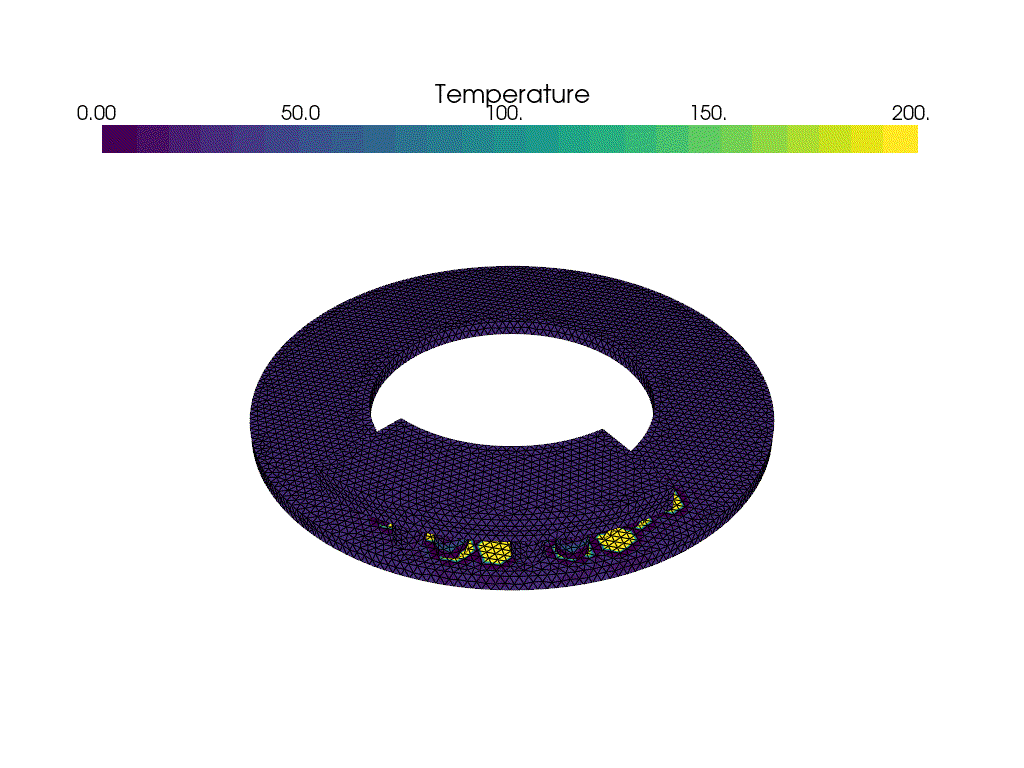

In [10]:
# Display the GIF
from IPython.display import display, Image
display(Image(filename = 'T4.gif'))

In [11]:
c = 1+ 2 \
+3
print(c)

6
